In this project ia am using this kaggle dataset:
    https://www.kaggle.com/datasets/emmarex/plantdisease

The dataset contains images of deceases from potatos, tomatos, and peppers. I am only going to work with the tomato images which have 10 classes. Healthy and 9 deceases.

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
import pandas as pd
import numpy as np
import os
import PIL

from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import RMSprop

We are working with a kaggle dataset that consists of tomatoes with various documented deceases. There are 10 classes and the classes are roughly even in terms of distribution, besides one (Tomato_mosiac_virus), which has fewer samples. I will try to augment that class so i get more data.

In [2]:
# defining constants. They help when we provide the input dimensions for the model

BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3

I saw that some images in the 'healthy' class contained not just the leaf, but also the tomatoes, which is not intended I believe. So i made a simple red filter that can be used to find some of the red images. It works by averaging the channels and selecting the images above a given threshold value

In [27]:
# For now i am just testing it on some hand picked images
red_data = tf.keras.preprocessing.image_dataset_from_directory(
    'red',
    seed=12345,
    shuffle=False
)

THRESHOLD = 140    
    
for images, labels in red_data:
    len_data = images.shape[0]
    break

for images, labels in red_data:
    for i in range(len_data):
        red_channel_avg = tf.reduce_mean(images[i, :, :, 0])  # Assuming red channel is at index 0
        green_channel_avg = tf.reduce_mean(images[i, :, :, 1])  # Assuming green channel is at index 1
        blue_channel_avg = tf.reduce_mean(images[i, :, :, 2])  # Assuming blue channel is at index 2

        print(f"Average Red Channel Value: {red_channel_avg}")
        print(f"Average Green Channel Value: {green_channel_avg}")
        print(f"Average Blue Channel Value: {blue_channel_avg}")
        if red_channel_avg > THRESHOLD:
            print(f'Found red picture at index {i}')
        print()
#* The index values should correspond to the image order in the selected folder (+1)  

Found 3 files belonging to 1 classes.
Average Red Channel Value: 159.01998901367188
Average Green Channel Value: 124.55427551269531
Average Blue Channel Value: 110.97279357910156
Found red picture at index 0

Average Red Channel Value: 107.58840942382812
Average Green Channel Value: 125.98605346679688
Average Blue Channel Value: 105.21070861816406

Average Red Channel Value: 108.23786926269531
Average Green Channel Value: 111.3485107421875
Average Blue Channel Value: 109.85562133789062



The original dataset is very big so picked some images from each class for EDA and testing. Also the smaller dataset has even class distribution

In [6]:
#
#* tensorflow image_dataset_from_directory lets you load images from directories where each sub-directory is becomes a specific class. The labels are derived from the sub-folders names

BATCH_SIZE = 32
IMAGE_SIZE = 256 # I reshaping the images from 256x256 to 128x128
CHANNELS=3

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'tomatoe_small',
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

#* Save the class names (which are derived from the sub-folder names)
class_names = dataset.class_names
class_names

Found 4000 files belonging to 10 classes.


['Tomato__Target_Spot',
 'bacterial_spot',
 'early_blight',
 'healthy',
 'late_blight',
 'leaf_mold',
 'mosaic_virus',
 'septoria_leaf_spot',
 'spider_mite',
 'yellow_curl_virus']

In [47]:
# counting how many images there are of each class. Tomato_mosiac_virus Minimum class has only 373 images
labels = []
for x, y in dataset:
    labels.append(y.numpy())

labels = np.concatenate(labels, axis=0)  # Assuming dataset was batched.
unique_labels, counts = np.unique(labels, return_counts=True)

print(F'{labels=}')
print(F'{unique_labels=}')
print(F'{counts=}')

# i had a loop before where you also got class names but i dont know where that code went :/
class_counts = [0] * len(unique_labels)

for _, labels in dataset:
    for label in labels:
        class_counts[label] += 1

print("Samples per class:")
for i, count in enumerate(class_counts):
    print(f"Class {i}: {count} samples")

labels=array([0, 0, 0, ..., 9, 9, 9])
unique_labels=array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
counts=array([403, 403, 409, 411, 402, 401, 373, 399, 400, 399], dtype=int64)


In [6]:
# Randomly selects 3 data in the tf.dataset
# I print the shape and the image so i get a small overview
for image_batch, labels_batch in dataset.take(3):
    print(image_batch.shape)
    # print(labels_batch.numpy())
    print(labels_batch)
    # print(image_batch[0])

(16, 128, 128, 3)
tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(16,), dtype=int32)
(16, 128, 128, 3)
tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(16,), dtype=int32)
(16, 128, 128, 3)
tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(16,), dtype=int32)
(16, 128, 128, 3)
tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(16,), dtype=int32)
(16, 128, 128, 3)
tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(16,), dtype=int32)
(16, 128, 128, 3)
tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(16,), dtype=int32)
(16, 128, 128, 3)
tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(16,), dtype=int32)
(16, 128, 128, 3)
tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(16,), dtype=int32)
(16, 128, 128, 3)
tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(16,), dtype=int32)
(16, 128, 128, 3)
tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(16,), dtype=int32)


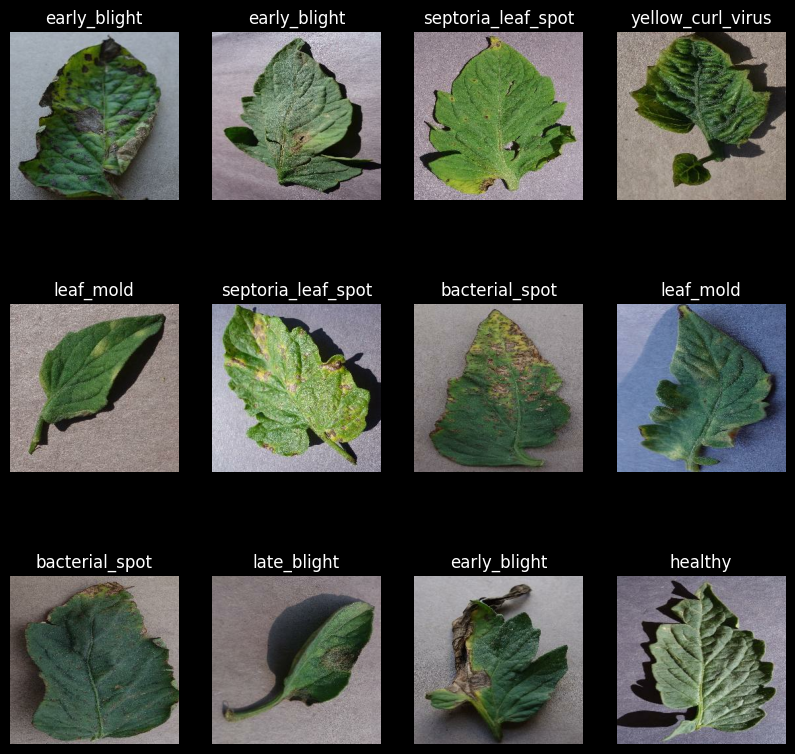

In [10]:
# An overview of some of the images
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
#
#? Function does almost the same thing as sklearn train_test_split function (but for tf.dataset)

def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

print(F'{train_ds=}')
print(F'{val_ds=}')
print(F'{test_ds=}')
print(F'{len(train_ds)=}')
print(F'{len(val_ds)=}')
print(F'{len(test_ds)=}')

train_ds=<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
val_ds=<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
test_ds=<_SkipDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
len(train_ds)=100
len(val_ds)=12
len(test_ds)=13


You can make preprocessing layers in tensorflow that you can either use on their own or use in a model. I experimented with data augmentation but it dit not help much. I think it would add more value if i had fewer data and i could train the models alot more

In [4]:
# in my case, resizing is not really necessary since i know all the images have the same resolution. This layer can still be used though if you want your model to be 'future proof' for future images with unknown resolution
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  tf.keras.layers.Rescaling(1./255),
])

# Some common image augmentation 
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.RandomContrast(0.2),
  tf.keras.layers.RandomBrightness(0.2)
])

#* Using the altered images did not improve my model training in this case
train_ds_aug = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

NameError: name 'train_ds' is not defined

Since the datasat is somewhat unbalanced (but only for 1 of the 10 classes) I try to create more image diversity within this minorty class by using the data_augmentation filter layer. i.e. i use the data_augmentation layer to create more images for the minority class so that the model encounters more diversity and numerosity of the class in question. 

It may not be necessary , but i save the changed images back to the hdd so that i dont have to re-generate the images each time.

In [34]:
folder_path = r"C:\Users\Magnus\Desktop\code\timeSeries\mosaic_virus"

# the minority class
mosaic_virus = tf.keras.preprocessing.image_dataset_from_directory(
    'mosaic_virus',
    seed=12345,
    shuffle=False
)

mosaic_virus_aug = mosaic_virus.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)

# Create a directory to save the images
save_dir = 'augmented_images'
os.makedirs(save_dir, exist_ok=True)

Found 373 files belonging to 1 classes.


In [37]:
# Initialize a counter
counter = 0
# Iterate over the dataset and save each image
for batch_images, batch_labels in mosaic_virus_aug:
    for image, label in zip(batch_images, batch_labels):
        # Convert the image tensor to a PIL image
        image_pil = PIL.Image.fromarray(image.numpy().astype(np.uint8))
        # Generate a unique filename based on the label and counter
        filename = f'label_{label.numpy()}_{counter}.jpg'
        # Save the image to the save directory
        image_pil.save(os.path.join(save_dir, filename))

        # Increment the counter
        counter += 1

I started off by working with a pretty standard CNV model. I wanted to see how much each layer would add to the accuracy. So the next few cells , i try adding more layers to see how it effects the results. As have been mentioned before, the accuracy did not really improve anyways due to the dataset size (and the decreased resolution could also have had an effect.) The plan was for this model to be the baseline model, but it did not turn out that way.

In [15]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
input_shape = (32, 64, 64, 3)

n_classes = 10

model_111 = models.Sequential([
    # data_augmentation,
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_24 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_24 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_25 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (32, 60, 60, 64)         

In [16]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
history = model.fit(train_ds, validation_data=val_ds, epochs=15)

Epoch 1/15
100/100 [==============================] - 147s 1s/step - loss: 0.2298 - accuracy: 0.9153 - val_loss: 0.2631 - val_accuracy: 0.8906
Epoch 2/15
100/100 [==============================] - 143s 1s/step - loss: 0.2448 - accuracy: 0.9097 - val_loss: 0.2585 - val_accuracy: 0.8984
Epoch 3/15
100/100 [==============================] - 154s 2s/step - loss: 0.1873 - accuracy: 0.9331 - val_loss: 0.1038 - val_accuracy: 0.9661
Epoch 4/15
100/100 [==============================] - 145s 1s/step - loss: 0.1669 - accuracy: 0.9419 - val_loss: 0.1594 - val_accuracy: 0.9531
Epoch 5/15
100/100 [==============================] - 138s 1s/step - loss: 0.1574 - accuracy: 0.9413 - val_loss: 0.1628 - val_accuracy: 0.9427
Epoch 6/15
100/100 [==============================] - 139s 1s/step - loss: 0.1944 - accuracy: 0.9325 - val_loss: 0.2487 - val_accuracy: 0.9297
Epoch 7/15
100/100 [==============================] - 137s 1s/step - loss: 0.1323 - accuracy: 0.9538 - val_loss: 0.1188 - val_accuracy: 0.9635

In [22]:
metrics = pd.DataFrame(history.history)
metrics.tail()

,loss,accuracy,val_loss,val_accuracy
10,0.357127,0.873125,0.440387,0.817708
11,0.339779,0.879062,0.288912,0.893229
12,0.379446,0.862813,0.380306,0.859375
13,0.326509,0.886250,0.276038,0.906250
14,0.263155,0.905625,0.139872,0.950521


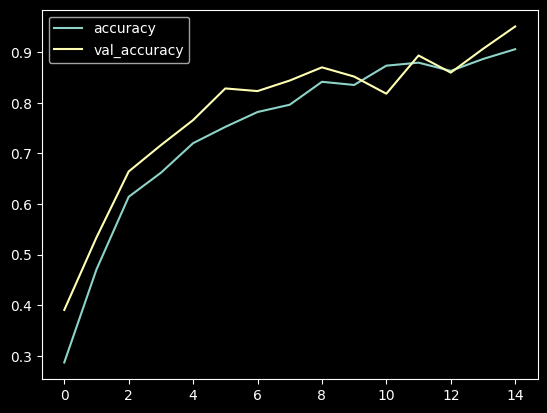

In [23]:
metrics[['accuracy','val_accuracy']].plot()
plt.show()

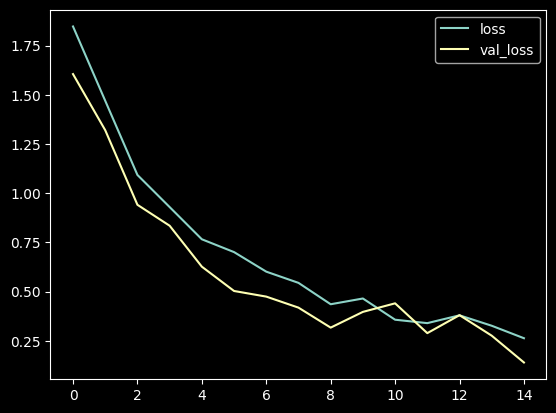

In [24]:
metrics[['loss','val_loss']].plot()
plt.show()

In [27]:
model_name = 'traditional_CONV_30E'
model.save(model_name)

INFO:tensorflow:Assets written to: traditional_CONV_30E\assets


INFO:tensorflow:Assets written to: traditional_CONV_30E\assets


98.9% is a very high validation accuracy! Pretty likely that there is some overfitting occuring. In tomatoe_tuning 1 and 2 (the notebooks), I will try some other model arechetcture. I also try with transfer learning in the tomatoe_transfer notebook

In [2]:
# I save this model and use it as a baseline
model = tf.keras.models.load_model('traditional_CONV_30E')
model_name = 'XXX'
os.makedirs(f'my_models/{model_name}', exist_ok=True)
model_version = '88'
model.save('my_models/{}/model_version_{}'.format(model_name,model_version))

Lets look at some predictions and confusion matrix

1/1 [==============================] - 0s 32ms/step


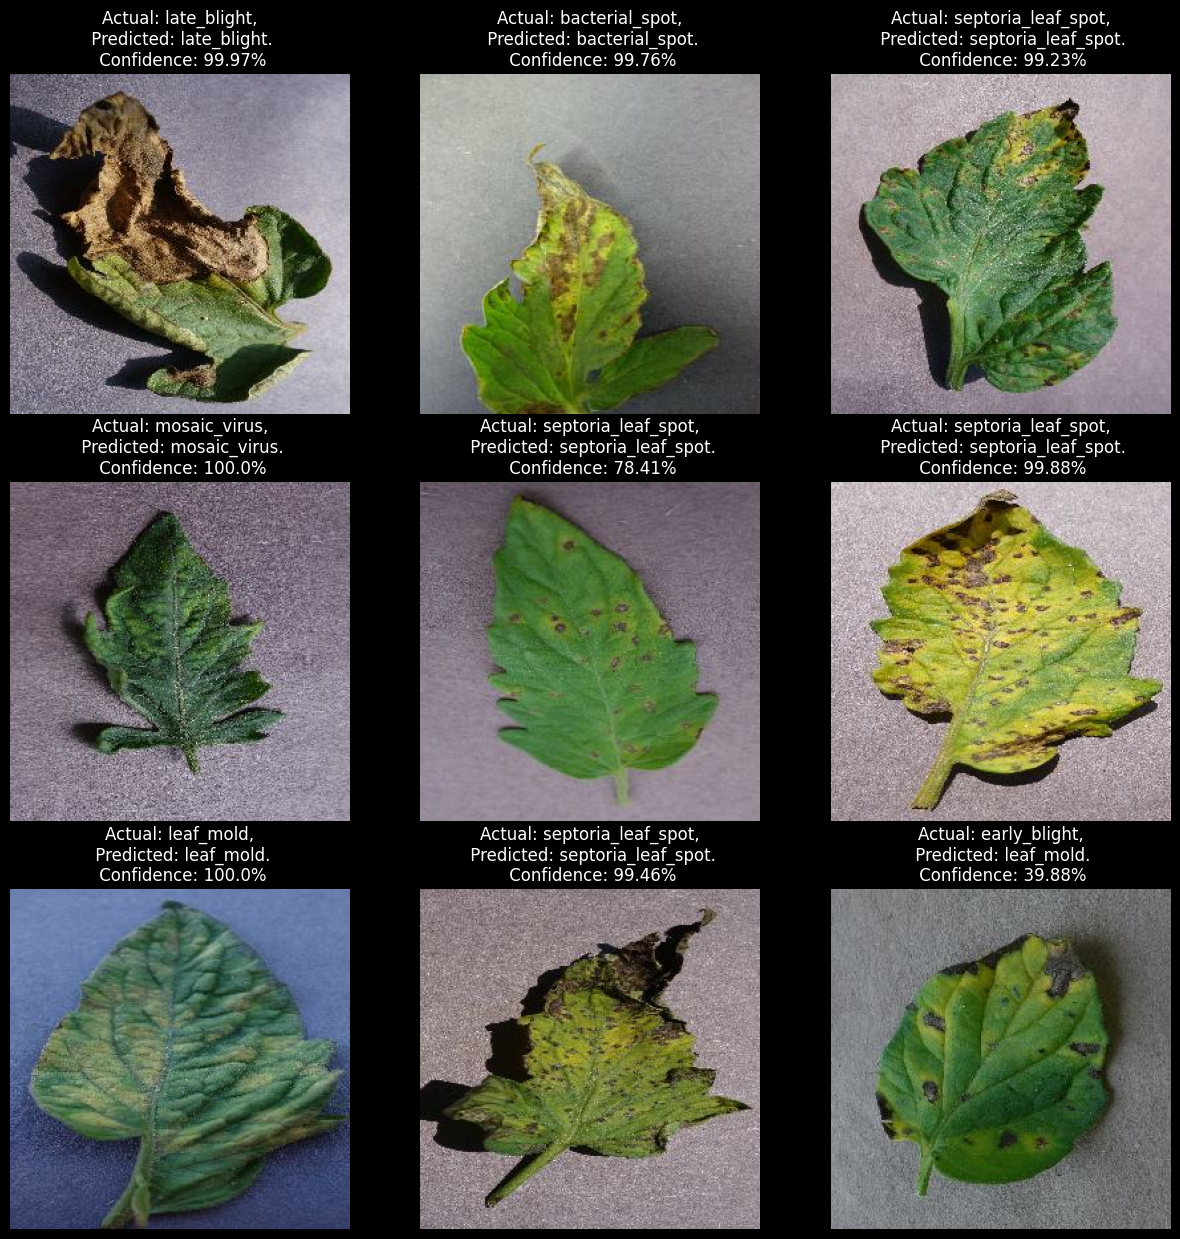

In [18]:
#
#? This function is a bit messy since test_ds is a tf.dataset. 

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence



plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

13/13 [==============================] - 5s 371ms/step
accuracy=0.9783653846153846
tf.Tensor(
[[38  0  0  0  0  0  0  0  1  0]
 [ 1 31  2  0  0  0  0  1  0  1]
 [ 0  0 44  0  0  0  0  0  0  0]
 [ 0  0  0 47  0  0  0  0  0  0]
 [ 0  0  0  0 49  0  0  0  0  0]
 [ 0  0  0  0  0 33  0  1  0  0]
 [ 0  0  0  0  0  0 36  0  0  0]
 [ 1  0  0  0  0  1  0 45  0  0]
 [ 0  0  0  0  0  0  0  0 37  0]
 [ 0  0  0  0  0  0  0  0  0 47]], shape=(10, 10), dtype=int32)


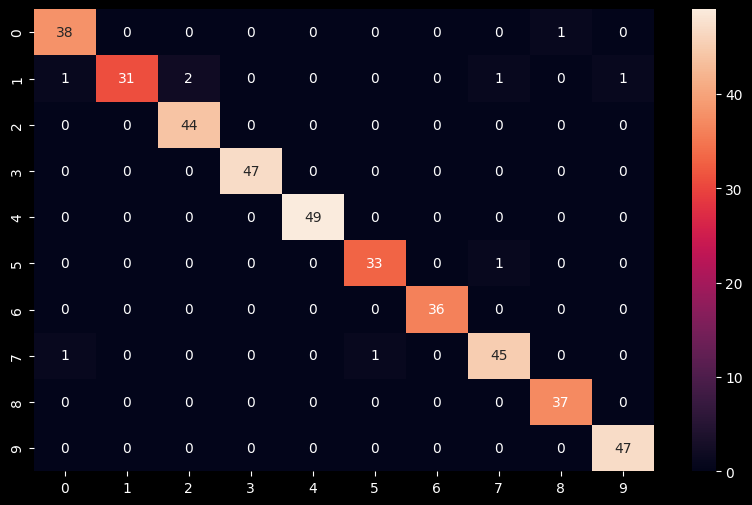

In [44]:
# Having my data in tf.dataset format has shown to be quite bothersome when you want to do other stuff besides model.fit. Maybe there is a better way to handle this?

test_data_list = []
test_labels_list = []

for test_batch in test_ds:
    # Split the batch into data and labels
    batch_data, batch_labels = test_batch

    # Append the data and labels to their respective lists
    test_data_list.append(batch_data.numpy())  # Assuming you're using TensorFlow
    test_labels_list.append(batch_labels.numpy())

# Concatenate the lists to obtain the final test_data and test_labels arrays
test_data = np.concatenate(test_data_list, axis=0)
test_labels = np.concatenate(test_labels_list, axis=0)

# Step 1: Get predicted probabilities
predicted_probabilities = model.predict(test_data)

# Step 2: Convert probabilities into class predictions
predicted_classes = np.argmax(predicted_probabilities, axis=1)

# Step 3: Compare with true labels
accuracy = np.mean(predicted_classes == test_labels)

print(f"{accuracy=}")

confusion_matrix = tf.math.confusion_matrix(test_labels, predicted_classes)
print(confusion_matrix)


cm_np = np.array(confusion_matrix)
import seaborn as sns
plt.figure(figsize=(10,6))
sns.heatmap(cm_np,annot=True)
plt.show()

Now we tested on the test set which is not advised and bad practice. Only two 1:s were wrongly predicted (class_names[1] is 'bacterial_spot')). They were predicted as class 7. And one one class 2 were wrongly preedicted as class 5. I ran this before and then the model had more incorrect predictions.